In [ ]:
!pip install bravado
!pip install cbio_py
!pip install geneview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import math
import seaborn as sns
from cbio_py import cbio_mod as cb
import matplotlib.pyplot as plt

In [ ]:
from bravado.client import SwaggerClient
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/api-docs',
                                    config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec": False})
dir(cbioportal) 
# https://docs.cbioportal.org/web-api-and-clients/
# https://pypi.org/project/cbio-py/                                   

['Cancer_Types',
 'Clinical_Attributes',
 'Clinical_Data',
 'Copy_Number_Segments',
 'Discrete_Copy_Number_Alterations',
 'Gene_Panel_Data',
 'Gene_Panels',
 'Generic_Assay_Data',
 'Generic_Assays',
 'Genes',
 'Info',
 'Molecular_Data',
 'Molecular_Profiles',
 'Mutations',
 'Patients',
 'Sample_Lists',
 'Samples',
 'Server_running_status',
 'Studies',
 'Treatments']

In [ ]:
def create_patient_df(data):
    df = pd.DataFrame(columns=('chromosome', 'start','end', 'copyNum'))
    for segment in data:
        chromosome = segment['chromosome']
        start = segment['start']
        end = segment['end']
        segmentMean = segment['segmentMean']
        copyNum = 2**(segmentMean+1)
        df = df.append({'chromosome': chromosome, 'start': start, 'end':end, 'copyNum':copyNum}, ignore_index=True)
    return df


In [ ]:
def create_all_chr_heatmap(data):
  df = create_patient_df(data)
  df_new = df.groupby(['chromosome']).mean()
  new_index=[int(x) for x in df_new.index]
  df_new['chromosome_num']=new_index
  df_new = df_new.sort_values(['chromosome_num'])
  df_new=df_new.drop(columns=['chromosome_num'])
  df_final = df_new.transpose()
  sns.set(rc={"figure.figsize":(20, 10)}) #width=3, #height=4
  sns.heatmap(df_final, cmap='seismic', square=True, cbar_kws={'orientation': 'horizontal'})




In [ ]:
studyId = 'acc_tcga'
#cb.getAllSamplesInStudy(studyId)
sampleId = 'TCGA-OR-A5J1-01'
data = cb.getCopyNumberSegmentsInSampleInStudy(studyId, sampleId, return_type = 'dict')

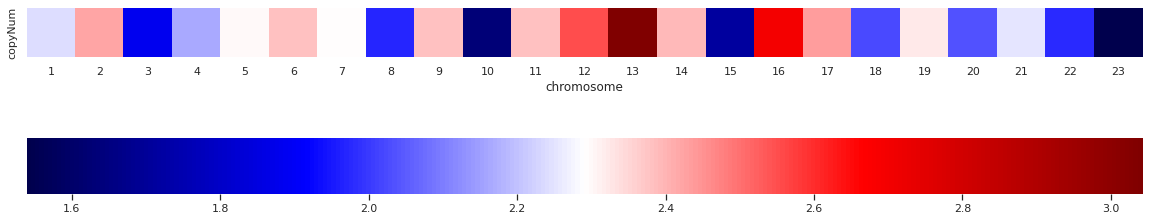

In [ ]:
create_all_chr_heatmap(data)

In [ ]:
def create_single_chr_heatmap(data, chr, bin_size=2500000):
  df = create_patient_df(data)
  chr_locs = np.where(df['chromosome'] == str(chr))[0]
  starts = np.array(df['start'][chr_locs[0] : chr_locs[-1]])
  ends = np.array(df['end'][chr_locs[0] : chr_locs[-1]])
  copy_nums = np.array(df['copyNum'][chr_locs[0] : chr_locs[-1]])
  chr_size = ends[len(ends) - 1]
  num_bins = int(chr_size/ bin_size) + 1
  bins = np.zeros(num_bins)

  for i in range(num_bins):
    temp = np.where((starts < (i*bin_size + bin_size))&(starts > (i*bin_size)))[0]
    for ele in temp:
      bins[i] += np.log2(copy_nums[ele] - 1)
  sns.set(rc={"figure.figsize":(20, 10)}) #width=3, #height=4
  sns.heatmap([bins], cmap='seismic', square=True, cbar_kws={'orientation': 'horizontal'}, center=0.0)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log2
  


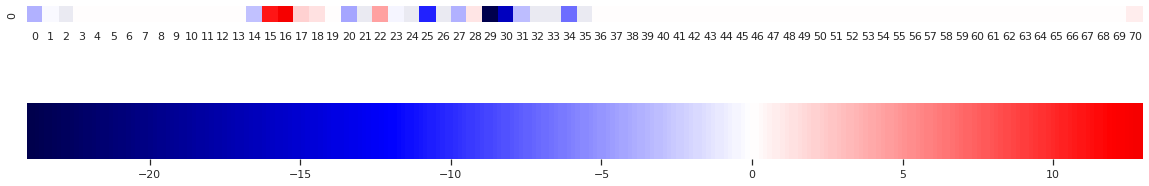

In [ ]:
create_single_chr_heatmap(data, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log2
  


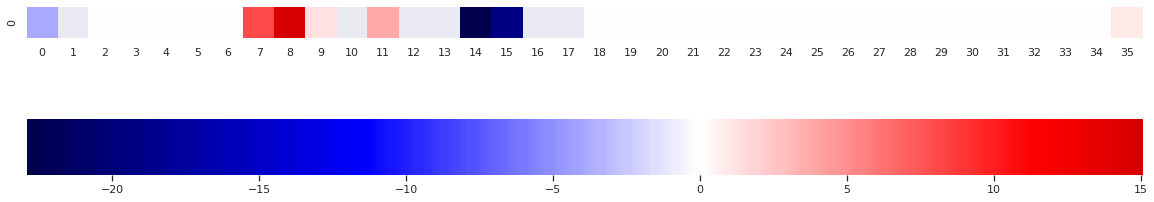

In [ ]:
create_single_chr_heatmap(data, 5, bin_size=5000000)

In [ ]:
df = create_patient_df(data)
np.array(df['start'][0:5])[0]

3218610

In [ ]:
def create_single_chr_bins(df, chr, num_bins=30):
  chr_locs = np.where(df['chromosome'] == str(chr))[0]
  starts = np.array(df['start'][chr_locs[0] : chr_locs[-1]])
  if len(chr_locs) > 1:
    ends = np.array(df['end'][chr_locs[0] : chr_locs[-1]])
  else:
    ends = np.array([df['end'][chr_locs[0]]])
  copy_nums = np.array(df['copyNum'][chr_locs[0] : chr_locs[-1]])
  chr_size = ends[len(ends) - 1]
  bin_size = int(chr_size / num_bins)
  bins = []
  for i in range(num_bins):
    locations = np.where((starts < (i*bin_size + bin_size))&(starts > (i*bin_size)))[0]
    bin_list = []
    for j in range(len(locations)):
      element = locations[j]
      if (copy_nums[element] - 1) > 0:
        bin_list.append(np.log2(copy_nums[element] - 1))
      else:
        bin_list.append(0)
    if len(bin_list) > 0:
      bins.append(np.mean(np.array(bin_list)))
    else:
      bins.append(0)
  return bins



def compare_chrom_tracks(data, chr, num_bins = 80):
  all_bins = []
  for dat in data:
    bins = create_single_chr_bins(dat, chr)
    all_bins.append(bins)
  avg = np.mean(np)
  sns.set(rc={"figure.figsize":(20, 20)}) #width=3, #height=4
  sns.heatmap(all_bins, cmap='seismic', square=True, cbar_kws={'orientation': 'horizontal'}, center=0.0)
  plt.title('Chromosome ' + str(chr))
  #sns.heatmap([bins2], cmap='seismic', square=True, cbar_kws={'orientation': 'horizontal'}, center=0.0)

  return np.corrcoef(all_bins)

In [ ]:
def make_all_chr_df(studyId, sampleId):
  data = cb.getCopyNumberSegmentsInSampleInStudy(studyId, sampleId, return_type = 'dict')
  df = create_patient_df(data)
  all_chr = []
  for i in range(23):
    all_chr.extend(create_single_chr_bins(df, i+1, num_bins=10))
    




In [ ]:
data1 = cb.getCopyNumberSegmentsInSampleInStudy('acc_tcga', 'TCGA-OR-A5J1-01', return_type = 'dict')
all_chr = []
df = create_patient_df(data1)
for i in range(23):
  all_chr.extend(create_single_chr_bins(df, i+1, num_bins=10))



[77109240]
[62219837]
[47678774]


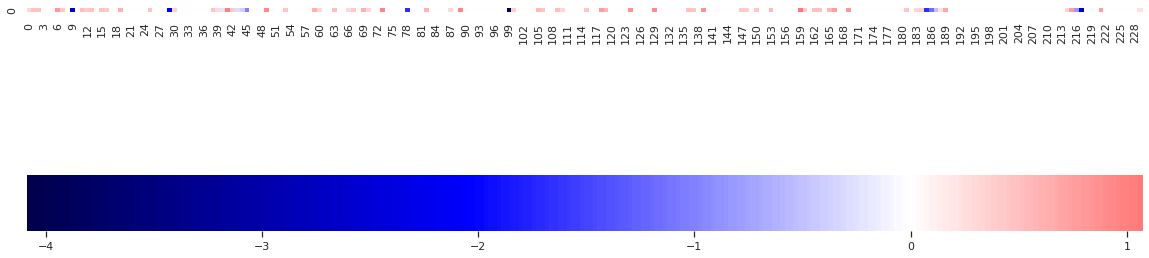

In [ ]:
sns.set(rc={"figure.figsize":(20, 20)}) #width=3, #height=4
sns.heatmap([all_chr], cmap='seismic', square=True, cbar_kws={'orientation': 'horizontal'}, center=0.0)

array([[ 1.       , -0.0087851],
       [-0.0087851,  1.       ]])

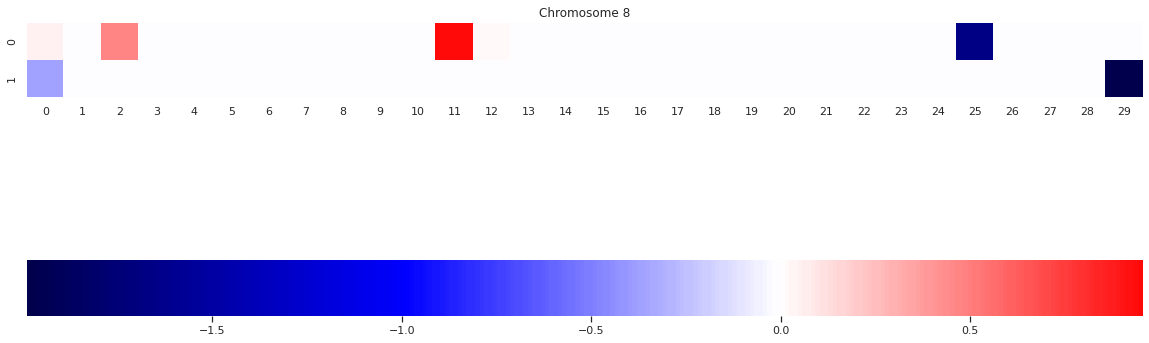

In [ ]:
data1 = cb.getCopyNumberSegmentsInSampleInStudy('acc_tcga', 'TCGA-OR-A5J1-01', return_type = 'dict')
data2 = cb.getCopyNumberSegmentsInSampleInStudy('acc_tcga', 'TCGA-PK-A5HC-01', return_type = 'dict')
data = [create_patient_df(data1), create_patient_df(data2)]
compare_chrom_tracks(data, 8)